## Preparing Data for Binary Classification

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

In [2]:
# prepare data
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [4]:
# init dataframe
circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                        'label': y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


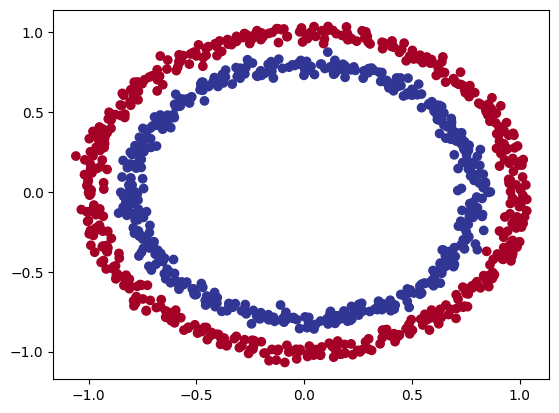

In [5]:
# visualize
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [6]:
# check I/O shapes
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# change from np to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [8]:
# train test split 80% - 20%
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
len(X_train), len(X_test)

(800, 200)

## Build the Model

In [10]:
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [11]:
# create the model
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        # init the model
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=1)
    
    # forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x goes into layer_1, which in turn goes into layer_2
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [12]:
# using nn.Sequential, same thing as above, less customizable
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [13]:
# make first predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n {torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
 tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.]])

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


#### Notes on Loss
* for regression maybe MAE or MSE is better
* for classification binary cross entropy or categorical cross entropy is better
* logits is the layer that feeds in to the softmax

#### Notes on Optimizer
* most common and useful are SGD and Adam

In [14]:
# loss setup

# loss_fn = nn.BCEloss() # requires inputs to have gone trhough sigmoid activation funciton
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function built-in (preferred, more stable)

# optim setup
optim = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [15]:
# accuracy calculation (useful for classification)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [16]:
# quick test
with torch.inference_mode():
    y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
y_preds_labels

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [17]:
torch.manual_seed(42)

# train
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()
    
    # forward pass and removing dim
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits into labels by passing through sigmoid and round
    
    # loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # optim zero grad
    optim.zero_grad()
    
    # backprop
    loss.backward()
    
    # optim step (gradient descent)
    optim.step()
    
    # eval loop
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # loss and acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71225 | Test loss: 0.70968, Test acc: 50.00%
Epoch: 10 | Loss: 0.69844 | Test loss: 0.69823, Test acc: 51.00%
Epoch: 20 | Loss: 0.69474 | Test loss: 0.69529, Test acc: 52.50%
Epoch: 30 | Loss: 0.69369 | Test loss: 0.69455, Test acc: 52.00%
Epoch: 40 | Loss: 0.69334 | Test loss: 0.69436, Test acc: 51.00%
Epoch: 50 | Loss: 0.69319 | Test loss: 0.69433, Test acc: 49.00%
Epoch: 60 | Loss: 0.69312 | Test loss: 0.69434, Test acc: 49.00%
Epoch: 70 | Loss: 0.69307 | Test loss: 0.69437, Test acc: 48.50%
Epoch: 80 | Loss: 0.69304 | Test loss: 0.69440, Test acc: 48.50%
Epoch: 90 | Loss: 0.69302 | Test loss: 0.69443, Test acc: 48.00%


In [18]:
# visualize

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

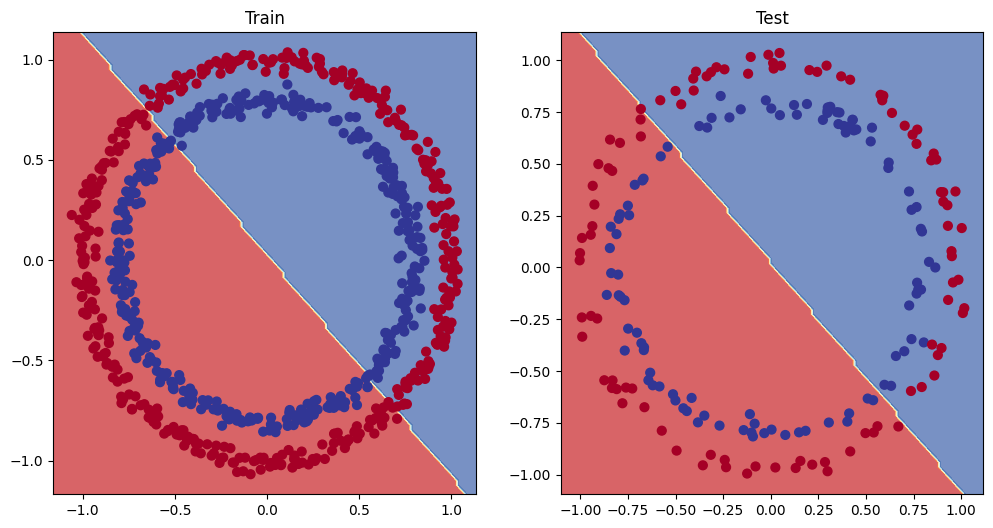

In [19]:
import numpy as np

# plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

#### Notes on model improvement
* add more layers
* add more hidden units
* fit for longer
* change the activation function
* change the learning rate
* change the loss function

In [20]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(in_features=2, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=16)
        self.layer_3 = nn.Linear(in_features=16, out_features=1)
        
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x))) # faster way of writing operations
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
)

In [21]:
# loss setup
loss_fn = nn.BCEWithLogitsLoss()

# optim setup
optim = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [22]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    
    # forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # optim zero grad()
    optim.zero_grad()
    
    # backprop
    loss.backward()
    
    # optim step
    optim.step()
    
    # eval loop
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69618, Acc: 50.00% | Test loss: 0.69344, Test acc: 50.00%
Epoch: 100 | Loss: 0.69300, Acc: 51.25% | Test loss: 0.69410, Test acc: 46.00%
Epoch: 200 | Loss: 0.69298, Acc: 51.25% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69466, Test acc: 46.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


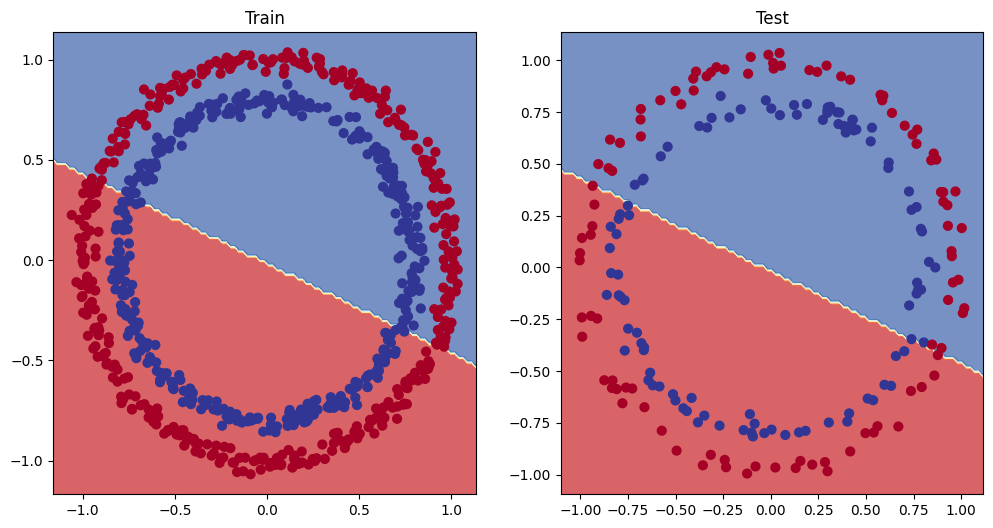

In [23]:
# plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### Adding Non Linearity

In [24]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(in_features=2, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=16)
        self.layer_3 = nn.Linear(in_features=16, out_features=1)
        self.relu = nn.ReLU() # non linear activation function
        
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [25]:
# loss setup
loss_fn = nn.BCEWithLogitsLoss()

# optim setup
optim = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [26]:
torch.manual_seed(42)

# train
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_2.train()
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optim.zero_grad()
    loss.backward()
    optim.step()

    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69753, Acc: 50.00% | Test loss: 0.69784, Test acc: 50.00%
Epoch: 100 | Loss: 0.68987, Acc: 56.25% | Test loss: 0.69139, Test acc: 51.50%
Epoch: 200 | Loss: 0.68663, Acc: 52.88% | Test loss: 0.68875, Test acc: 52.00%
Epoch: 300 | Loss: 0.68264, Acc: 53.62% | Test loss: 0.68576, Test acc: 52.50%
Epoch: 400 | Loss: 0.67735, Acc: 54.00% | Test loss: 0.68189, Test acc: 53.50%
Epoch: 500 | Loss: 0.67006, Acc: 56.00% | Test loss: 0.67640, Test acc: 55.50%
Epoch: 600 | Loss: 0.65938, Acc: 62.38% | Test loss: 0.66777, Test acc: 58.00%
Epoch: 700 | Loss: 0.64168, Acc: 75.50% | Test loss: 0.65325, Test acc: 68.50%
Epoch: 800 | Loss: 0.61284, Acc: 87.38% | Test loss: 0.62886, Test acc: 85.00%
Epoch: 900 | Loss: 0.56398, Acc: 97.25% | Test loss: 0.58723, Test acc: 93.00%


In [27]:
# manual eval
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

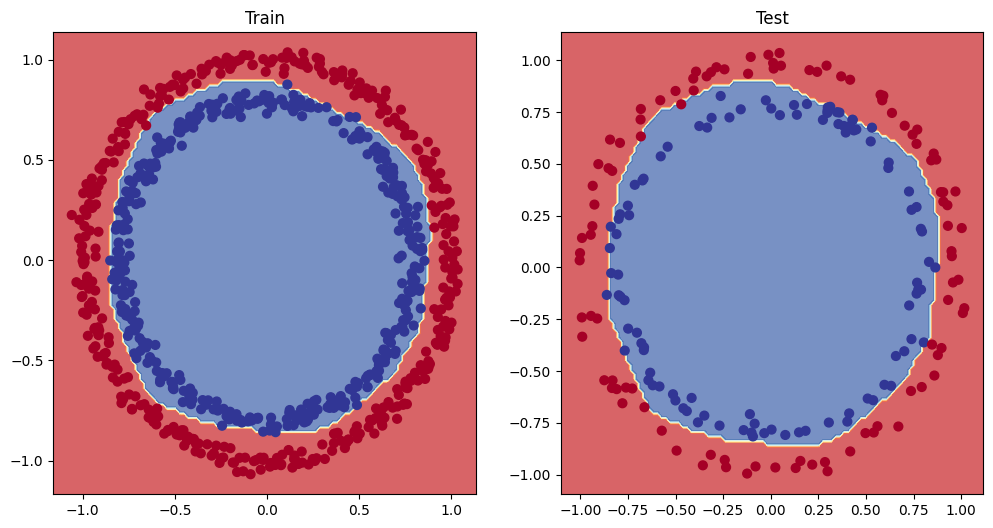

In [28]:
# plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_2, X_test, y_test)

## Multiclass Classification Problem

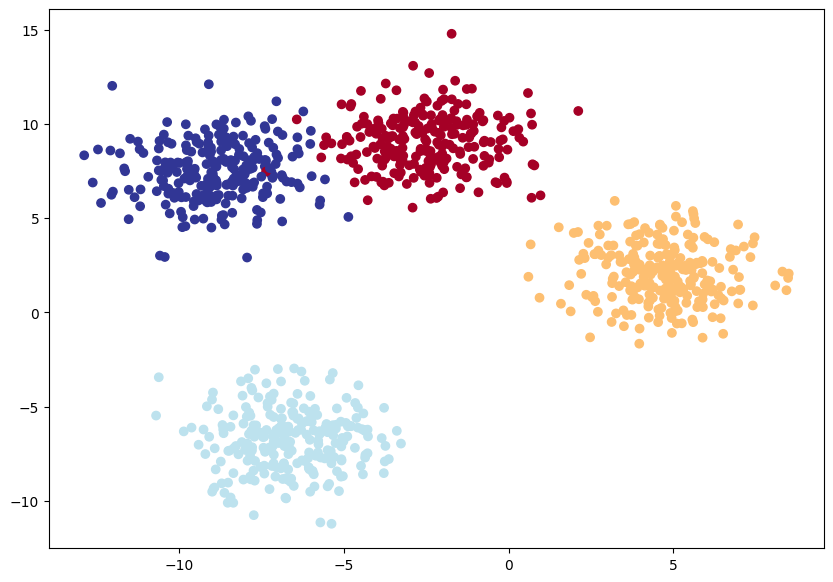

In [29]:
# create data
from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2
SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=SEED)

# turn into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=SEED)

# visualize
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [30]:
# build the model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
        
    def forward(self, x):
        return self.linear_layer_stack(x)

model_3 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [31]:
# loss/acc (loss for multiclass problem - entropy) and optim
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [32]:
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()
    y_logits = model_3(X_train)
    
    # using softmax and argmax to get lables in multi class!
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optim.zero_grad()
    loss.backward()
    optim.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test)
        # using softmax and argmax to get lables in multi class!
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test loss: 1.07554, Test acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test loss: 0.66069, Test acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test loss: 0.43074, Test acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test loss: 0.24508, Test acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test loss: 0.10229, Test acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test loss: 0.05848, Test acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test loss: 0.04293, Test acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test loss: 0.03491, Test acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test loss: 0.02988, Test acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test loss: 0.02663, Test acc: 99.50%


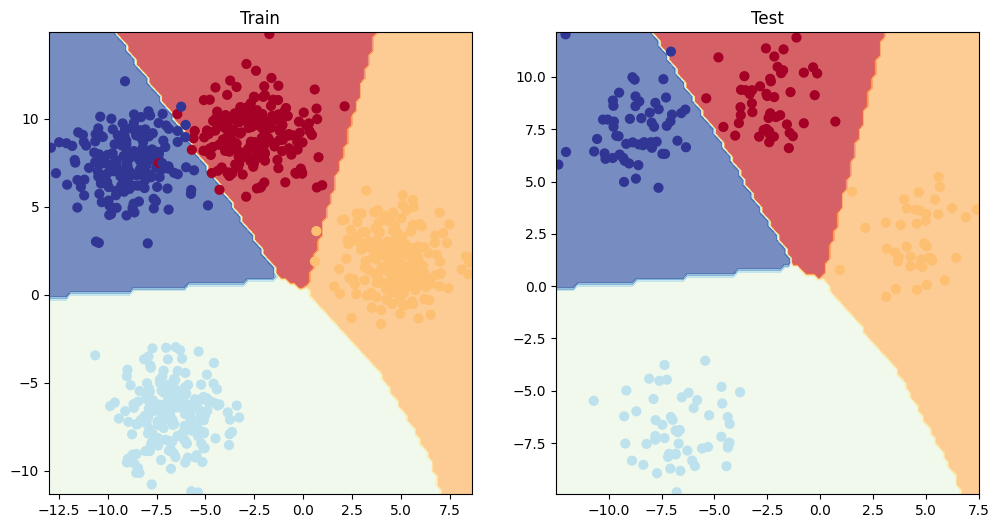

In [33]:
# plot decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)